# N-BEATS 


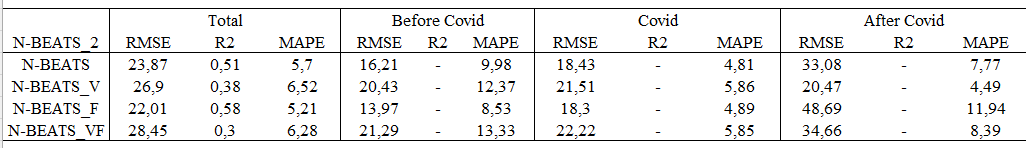, 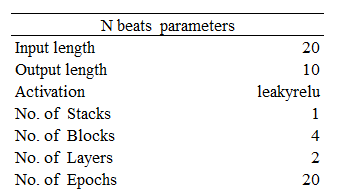

In [1]:
import pandas as pd
import numpy as np
import darts
import yfinance as yf

# visualization
import matplotlib.pyplot as plt

# timeseries with darts
import torch
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.dataprocessing.transformers import MissingValuesFiller
from darts import concatenate
from darts.models import NBEATSModel

# RF model test with Covariate
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# darts model evaluation
from darts.metrics import mape, rmse, r2_score

c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
The statsforecast module could not be imported. To enable support for the StatsForecastAutoARIMA, StatsForecastAutoETS and Croston models, please consider installing it.


In [2]:
df =pd.read_csv(r'C:\Users\dicod\Documents\2024\project_with Hamid(2024_3rd semester)\Scientific Project\Data\final_df.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
df['Date'] = df['Date'].apply(lambda x:x[0:10])
df['Date'] = pd.to_datetime(df['Date'])


# dataframe to timeseries
ts_price = TimeSeries.from_dataframe(df, time_col=None, value_cols='Close', fill_missing_dates=False, freq='D')
ts_Volume = TimeSeries.from_dataframe(df, time_col=None, value_cols='Volume', fill_missing_dates=False, freq='D')
ts_EPS = TimeSeries.from_dataframe(df, time_col=None, value_cols='EPS', fill_missing_dates=False, freq='D')
ts_PE = TimeSeries.from_dataframe(df, time_col=None, value_cols='P/E', fill_missing_dates=False, freq='D')
ts_PS = TimeSeries.from_dataframe(df, time_col=None, value_cols='P/S', fill_missing_dates=False, freq='D')

# Missing value fillin
transformer = MissingValuesFiller()

ts_price = transformer.transform(ts_price)
ts_Volume = transformer.transform(ts_Volume)
ts_EPS = transformer.transform(ts_EPS)
ts_PE = transformer.transform(ts_PE)
ts_PS = transformer.transform(ts_PS)

# scaler
scaler = Scaler()
scaled_price, scaled_Volume, scaled_EPS, scaled_PE, scaled_PS = scaler.fit_transform([ts_price, ts_Volume, ts_EPS, ts_PE, ts_PS] )

# concate
my_multivariate_series = concatenate([scaled_price, scaled_Volume, scaled_EPS, scaled_PE, scaled_PS], axis=1)

# After COVID (from February 1, 2022)
before, after_covid = my_multivariate_series.split_after(653)
                                                        
# Before COVID (up to March 11, 2020)
before_covid, covid = before.split_after(174)

# data split the train and test
train, test = my_multivariate_series.split_after(0.8)
train_covid, test_covid = covid.split_after(0.8)
train_before_covid, test_before_covid = before_covid.split_after(0.8)
train_after_covid, test_after_covid = after_covid.split_after(0.8)

In [3]:
# define the covariates using train and validation data
# total period
past_cov = my_multivariate_series['Volume']
past_cov_train_vol = train['Volume']
past_cov_test_vol = test['Volume']
past_cov_f = my_multivariate_series[['EPS', 'P/E', 'P/S']]
past_cov_train_f = train[['EPS', 'P/E', 'P/S']]
past_cov_test_f = test[['EPS', 'P/E', 'P/S']]
past_cov_vf = my_multivariate_series[['Volume', 'EPS', 'P/E', 'P/S']]
past_cov_train_vf = train[['Volume', 'EPS', 'P/E', 'P/S']]
past_cov_test_vf = test[['Volume', 'EPS', 'P/E', 'P/S']]

# before covid
pc_train_before_vol = train_before_covid['Volume']
pc_test_before_vol = test_before_covid['Volume'] 
pc_train_before_f = train_before_covid[['EPS', 'P/E', 'P/S']]
pc_test_before_f = test_before_covid[['EPS', 'P/E', 'P/S']] 
pc_train_before_vf = train_before_covid[['Volume', 'EPS', 'P/E', 'P/S']]
pc_test_before_vf = test_before_covid[['Volume', 'EPS', 'P/E', 'P/S']] 

# covid
pc_train_covid_vol = train_covid['Volume']
pc_test_covid_vol = test_covid['Volume']
pc_train_covid_f = train_covid[['EPS', 'P/E', 'P/S']]
pc_test_covid_f = test_covid[['EPS', 'P/E', 'P/S']]
pc_train_covid_vf = train_covid[['Volume', 'EPS', 'P/E', 'P/S']]
pc_test_covid_vf = test_covid[['Volume', 'EPS', 'P/E', 'P/S']]

# after covid
pc_train_after_covid_vol = train_after_covid['Volume']
pc_test_after_covid_vol = test_after_covid['Volume']
pc_train_after_covid_f = train_after_covid[['EPS', 'P/E', 'P/S']]
pc_test_after_covid_f = test_after_covid[['EPS', 'P/E', 'P/S']]
pc_train_after_covid_vf = train_after_covid[['Volume', 'EPS', 'P/E', 'P/S']]
pc_test_after_covid_vf = test_after_covid[['Volume', 'EPS', 'P/E', 'P/S']]

# Experiment with Covariates

1. Covariate with volume
2. Covariate with Fundamental data
3. Covariates with Volume and fundamental data

### Table 1. 

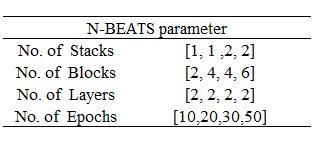

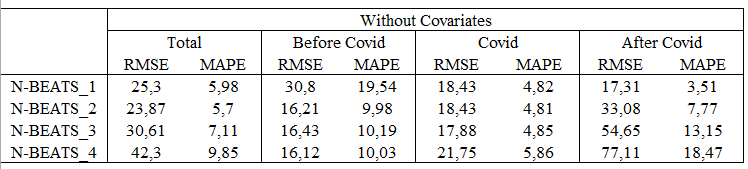


### Without Covariates

In [12]:
# model_par1 define 
model_par_1 = NBEATSModel(
    input_chunk_length=20,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=1, num_blocks=2, num_layers=1,
    n_epochs=10,
    activation='LeakyReLU',
    dropout=0.001,
    random_state = 42
)
# total 
model_par_1.fit(train['Close'])
pred_series = model_par_1.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test['Close'])

# Model Evaluation
print("NBEATS_total_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_total_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_total_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# Before Covid
model_par_1.fit(train_before_covid['Close'])
pred_series = model_par_1.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_before_covid['Close'])

# Model Evaluation
print("NBEATS_Covid_Before_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_Covid_Before_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_Covid_Before_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# Covid
model_par_1.fit(train_covid['Close'])
pred_series = model_par_1.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_covid['Close'])

# Model Evaluation
print("NBEATS_Covid_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_Covid_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_Covid_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# After Covid
model_par_1.fit(train_after_covid['Close'])
pred_series = model_par_1.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_after_covid['Close'])

# Model Evaluation
print("NBEATS_After_Covid_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_After_Covid_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_After_Covid_M1 MAPE = %.2f" % mape(actual_price, pred_price))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 16.3 K
---------------------------------------------------
14.8 K    Trainable params
1.4 K     Non-trainable params
16.3 K    Total params
0.065     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_total_M1 RMSE = 25.30
NBEATS_total_M1 R2 = 0.45
NBEATS_total_M1 MAPE = 5.98


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_Covid_Before_M1 RMSE = 30.80
NBEATS_Covid_Before_M1 R2 = -25.89
NBEATS_Covid_Before_M1 MAPE = 19.54


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_Covid_M1 RMSE = 18.43
NBEATS_Covid_M1 R2 = -0.83
NBEATS_Covid_M1 MAPE = 4.82


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_After_Covid_M1 RMSE = 17.31
NBEATS_After_Covid_M1 R2 = 0.17
NBEATS_After_Covid_M1 MAPE = 3.51


In [13]:
# model_par1 define 
model_par_2 = NBEATSModel(
    input_chunk_length=20,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=1, num_blocks=4, num_layers=2,
    n_epochs=20,
    activation='LeakyReLU',
    dropout=0.001,
    random_state = 42
)
# total 
model_par_2.fit(train['Close'])
pred_series = model_par_2.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test['Close'])

# Model Evaluation
print("NBEATS_total_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_total_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_total_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# Before Covid
model_par_2.fit(train_before_covid['Close'])
pred_series = model_par_2.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_before_covid['Close'])

# Model Evaluation
print("NBEATS_Covid_Before_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_Covid_Before_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_Covid_Before_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# Covid
model_par_2.fit(train_covid['Close'])
pred_series = model_par_2.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_covid['Close'])

# Model Evaluation
print("NBEATS_Covid_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_Covid_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_Covid_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# After Covid
model_par_2.fit(train_after_covid['Close'])
pred_series = model_par_2.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_after_covid['Close'])

# Model Evaluation
print("NBEATS_After_Covid_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_After_Covid_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_After_Covid_M1 MAPE = %.2f" % mape(actual_price, pred_price))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 295 K 
---------------------------------------------------
294 K     Trainable params
1.4 K     Non-trainable params
295 K     Total params
1.183     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_total_M1 RMSE = 23.87
NBEATS_total_M1 R2 = 0.51
NBEATS_total_M1 MAPE = 5.70


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_Covid_Before_M1 RMSE = 16.21
NBEATS_Covid_Before_M1 R2 = -6.45
NBEATS_Covid_Before_M1 MAPE = 9.98


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_Covid_M1 RMSE = 18.43
NBEATS_Covid_M1 R2 = -0.83
NBEATS_Covid_M1 MAPE = 4.81


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_After_Covid_M1 RMSE = 33.08
NBEATS_After_Covid_M1 R2 = -2.02
NBEATS_After_Covid_M1 MAPE = 7.77


In [21]:
model_par_3 = NBEATSModel(
    input_chunk_length=20,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=2, num_blocks=4, num_layers=2,
    n_epochs=30,
    activation='LeakyReLU',
    dropout=0.001,
    random_state = 42
)
# total 
model_par_3.fit(train['Close'])
pred_series = model_par_3.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test['Close'])

# Model Evaluation
print("NBEATS_total_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_total_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_total_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# Before Covid
model_par_3.fit(train_before_covid['Close'])
pred_series = model_par_3.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_before_covid['Close'])

# Model Evaluation
print("NBEATS_Covid_Before_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_Covid_Before_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_Covid_Before_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# Covid
model_par_3.fit(train_covid['Close'])
pred_series = model_par_3.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_covid['Close'])

# Model Evaluation
print("NBEATS_Covid_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_Covid_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_Covid_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# After Covid
model_par_3.fit(train_after_covid['Close'])
pred_series = model_par_3.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_after_covid['Close'])

# Model Evaluation
print("NBEATS_After_Covid_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_After_Covid_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_After_Covid_M1 MAPE = %.2f" % mape(actual_price, pred_price))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 591 K 
---------------------------------------------------
589 K     Trainable params
1.4 K     Non-trainable params
591 K     Total params
2.365     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_total_M1 RMSE = 30.61
NBEATS_total_M1 R2 = 0.19
NBEATS_total_M1 MAPE = 7.11


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_Covid_Before_M1 RMSE = 16.43
NBEATS_Covid_Before_M1 R2 = -6.65
NBEATS_Covid_Before_M1 MAPE = 10.19


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_Covid_M1 RMSE = 17.88
NBEATS_Covid_M1 R2 = -0.72
NBEATS_Covid_M1 MAPE = 4.85


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_After_Covid_M1 RMSE = 54.65
NBEATS_After_Covid_M1 R2 = -7.25
NBEATS_After_Covid_M1 MAPE = 13.15


In [15]:
model_par_4 = NBEATSModel(
    input_chunk_length=20,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=2, num_blocks=6, num_layers=2,
    n_epochs=50,
    activation='LeakyReLU',
    dropout=0.001,
    random_state = 42
)
# total 
model_par_4.fit(train['Close'])
pred_series = model_par_4.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test['Close'])

# Model Evaluation
print("NBEATS_total_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_total_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_total_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# Before Covid
model_par_4.fit(train_before_covid['Close'])
pred_series = model_par_4.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_before_covid['Close'])

# Model Evaluation
print("NBEATS_Covid_Before_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_Covid_Before_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_Covid_Before_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# Covid
model_par_4.fit(train_covid['Close'])
pred_series = model_par_4.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_covid['Close'])

# Model Evaluation
print("NBEATS_Covid_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_Covid_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_Covid_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# After Covid
model_par_4.fit(train_after_covid['Close'])
pred_series = model_par_4.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_after_covid['Close'])

# Model Evaluation
print("NBEATS_After_Covid_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_After_Covid_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_After_Covid_M1 MAPE = %.2f" % mape(actual_price, pred_price))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 887 K 
---------------------------------------------------
885 K     Trainable params
1.4 K     Non-trainable params
887 K     Total params
3.548     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_total_M1 RMSE = 42.30
NBEATS_total_M1 R2 = -0.55
NBEATS_total_M1 MAPE = 9.85


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_Covid_Before_M1 RMSE = 16.12
NBEATS_Covid_Before_M1 R2 = -6.37
NBEATS_Covid_Before_M1 MAPE = 10.03


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_Covid_M1 RMSE = 21.75
NBEATS_Covid_M1 R2 = -1.55
NBEATS_Covid_M1 MAPE = 5.86


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_After_Covid_M1 RMSE = 77.11
NBEATS_After_Covid_M1 R2 = -15.43
NBEATS_After_Covid_M1 MAPE = 18.47


### 1. Covariate with Technical Data(volume)

### Table 3.

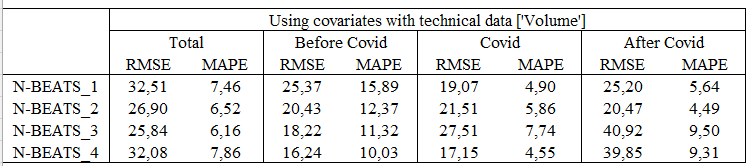

In [5]:
# model_par1 define 
model_par_1 = NBEATSModel(
    input_chunk_length=20,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=1, num_blocks=2, num_layers=1,
    n_epochs=10,
    activation='LeakyReLU',
    dropout=0.001,
    random_state = 42
)
# total 
model_par_1.fit(train['Close'], past_covariates=past_cov_train_vol)
pred_series = model_par_1.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_test_vol,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test['Close'])

# Model Evaluation
print("NBEATS_total_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_total_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_total_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# Before Covid
model_par_1.fit(train_before_covid['Close'], past_covariates=pc_train_before_vol)
pred_series = model_par_1.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_before_vol,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_before_covid['Close'])

# Model Evaluation
print("NBEATS_Covid_Before_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_Covid_Before_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_Covid_Before_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# Covid
model_par_1.fit(train_covid['Close'], past_covariates=pc_train_covid_vol)
pred_series = model_par_1.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_covid_vol,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_covid['Close'])

# Model Evaluation
print("NBEATS_Covid_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_Covid_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_Covid_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# After Covid
model_par_1.fit(train_after_covid['Close'], past_covariates=pc_train_after_covid_vol)
pred_series = model_par_1.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_after_covid_vol,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_after_covid['Close'])

# Model Evaluation
print("NBEATS_After_Covid_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_After_Covid_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_After_Covid_M1 MAPE = %.2f" % mape(actual_price, pred_price))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 26.9 K
---------------------------------------------------
25.3 K    Trainable params
1.5 K     Non-trainable params
26.9 K    Total params
0.107     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_total_M1 RMSE = 32.51
NBEATS_total_M1 R2 = 0.09
NBEATS_total_M1 MAPE = 7.46


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_Covid_Before_M1 RMSE = 25.37
NBEATS_Covid_Before_M1 R2 = -17.25
NBEATS_Covid_Before_M1 MAPE = 15.89


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_Covid_M1 RMSE = 19.07
NBEATS_Covid_M1 R2 = -0.96
NBEATS_Covid_M1 MAPE = 4.90


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_After_Covid_M1 RMSE = 25.20
NBEATS_After_Covid_M1 R2 = -0.75
NBEATS_After_Covid_M1 MAPE = 5.64


In [6]:

model_par_2 = NBEATSModel(
    input_chunk_length=20,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=1, num_blocks=4, num_layers=2,
    n_epochs=20,
    activation='LeakyReLU',
    dropout=0.001,
    random_state = 42
)
# total 
model_par_2.fit(train['Close'], past_covariates=past_cov_train_vol)
pred_series = model_par_2.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_test_vol,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test['Close'])

# Model Evaluation
print("NBEATS_total_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_total_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_total_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# Before Covid
model_par_2.fit(train_before_covid['Close'], past_covariates=pc_train_before_vol)
pred_series = model_par_2.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_before_vol,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_before_covid['Close'])

# Model Evaluation
print("NBEATS_Covid_Before_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_Covid_Before_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_Covid_Before_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# Covid
model_par_2.fit(train_covid['Close'], past_covariates=pc_train_covid_vol)
pred_series = model_par_2.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_covid_vol,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_covid['Close'])

# Model Evaluation
print("NBEATS_Covid_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_Covid_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_Covid_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# After Covid
model_par_2.fit(train_after_covid['Close'], past_covariates=pc_train_after_covid_vol)
pred_series = model_par_2.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_after_covid_vol,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_after_covid['Close'])

# Model Evaluation
print("NBEATS_After_Covid_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_After_Covid_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_After_Covid_M1 MAPE = %.2f" % mape(actual_price, pred_price))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 316 K 
---------------------------------------------------
315 K     Trainable params
1.5 K     Non-trainable params
316 K     Total params
1.267     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_total_M1 RMSE = 26.90
NBEATS_total_M1 R2 = 0.38
NBEATS_total_M1 MAPE = 6.52


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_Covid_Before_M1 RMSE = 20.43
NBEATS_Covid_Before_M1 R2 = -10.83
NBEATS_Covid_Before_M1 MAPE = 12.37


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_Covid_M1 RMSE = 21.51
NBEATS_Covid_M1 R2 = -1.49
NBEATS_Covid_M1 MAPE = 5.86


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_After_Covid_M1 RMSE = 20.47
NBEATS_After_Covid_M1 R2 = -0.16
NBEATS_After_Covid_M1 MAPE = 4.49


In [22]:
model_par_3 = NBEATSModel(
    input_chunk_length=20,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=2, num_blocks=4, num_layers=2,
    n_epochs=30,
    activation='LeakyReLU',
    dropout=0.001,
    random_state = 42
)
# total 
model_par_3.fit(train['Close'], past_covariates=past_cov_train_vol)
pred_series = model_par_3.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_test_vol,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test['Close'])

# Model Evaluation
print("NBEATS_total_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_total_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_total_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# Before Covid
model_par_3.fit(train_before_covid['Close'], past_covariates=pc_train_before_vol)
pred_series = model_par_3.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_before_vol,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_before_covid['Close'])

# Model Evaluation
print("NBEATS_Covid_Before_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_Covid_Before_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_Covid_Before_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# Covid
model_par_3.fit(train_covid['Close'], past_covariates=pc_train_covid_vol)
pred_series = model_par_3.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_covid_vol,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_covid['Close'])

# Model Evaluation
print("NBEATS_Covid_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_Covid_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_Covid_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# After Covid
model_par_3.fit(train_after_covid['Close'], past_covariates=pc_train_after_covid_vol)
pred_series = model_par_3.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_after_covid_vol,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_after_covid['Close'])

# Model Evaluation
print("NBEATS_After_Covid_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_After_Covid_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_After_Covid_M1 MAPE = %.2f" % mape(actual_price, pred_price))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 633 K 
---------------------------------------------------
632 K     Trainable params
1.5 K     Non-trainable params
633 K     Total params
2.535     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_total_M1 RMSE = 25.84
NBEATS_total_M1 R2 = 0.42
NBEATS_total_M1 MAPE = 6.16


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_Covid_Before_M1 RMSE = 18.22
NBEATS_Covid_Before_M1 R2 = -8.41
NBEATS_Covid_Before_M1 MAPE = 11.32


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_Covid_M1 RMSE = 27.51
NBEATS_Covid_M1 R2 = -3.08
NBEATS_Covid_M1 MAPE = 7.74


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_After_Covid_M1 RMSE = 40.92
NBEATS_After_Covid_M1 R2 = -3.63
NBEATS_After_Covid_M1 MAPE = 9.50


In [8]:
model_par_4 = NBEATSModel(
    input_chunk_length=20,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=2, num_blocks=6, num_layers=2,
    n_epochs=50,
    activation='LeakyReLU',
    dropout=0.001,
    random_state = 42
)
# total 
model_par_4.fit(train['Close'], past_covariates=past_cov_train_vol)
pred_series = model_par_4.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_test_vol,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test['Close'])

# Model Evaluation
print("NBEATS_total_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_total_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_total_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# Before Covid
model_par_4.fit(train_before_covid['Close'], past_covariates=pc_train_before_vol)
pred_series = model_par_4.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_before_vol,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_before_covid['Close'])

# Model Evaluation
print("NBEATS_Covid_Before_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_Covid_Before_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_Covid_Before_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# Covid
model_par_4.fit(train_covid['Close'], past_covariates=pc_train_covid_vol)
pred_series = model_par_4.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_covid_vol,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_covid['Close'])

# Model Evaluation
print("NBEATS_Covid_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_Covid_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_Covid_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# After Covid
model_par_4.fit(train_after_covid['Close'], past_covariates=pc_train_after_covid_vol)
pred_series = model_par_4.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_after_covid_vol,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_after_covid['Close'])

# Model Evaluation
print("NBEATS_After_Covid_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_After_Covid_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_After_Covid_M1 MAPE = %.2f" % mape(actual_price, pred_price))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 950 K 
---------------------------------------------------
949 K     Trainable params
1.5 K     Non-trainable params
950 K     Total params
3.802     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_total_M1 RMSE = 32.08
NBEATS_total_M1 R2 = 0.11
NBEATS_total_M1 MAPE = 7.86


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_Covid_Before_M1 RMSE = 16.24
NBEATS_Covid_Before_M1 R2 = -6.48
NBEATS_Covid_Before_M1 MAPE = 10.03


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_Covid_M1 RMSE = 17.15
NBEATS_Covid_M1 R2 = -0.58
NBEATS_Covid_M1 MAPE = 4.55


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_After_Covid_M1 RMSE = 39.85
NBEATS_After_Covid_M1 R2 = -3.39
NBEATS_After_Covid_M1 MAPE = 9.31


### 2. Covariate with Fundamental data (EPS, P/E, P/S)

### Table 3.

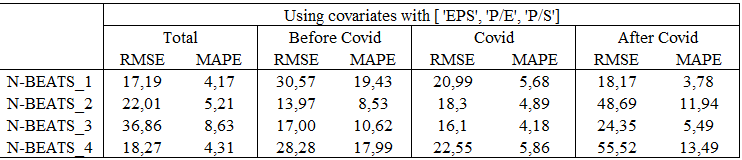

In [9]:
# model_par1 define 
model_par_1 = NBEATSModel(
    input_chunk_length=20,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=1, num_blocks=2, num_layers=1,
    n_epochs=10,
    activation='LeakyReLU',
    dropout=0.001,
    random_state = 42
)
# total 
model_par_1.fit(train['Close'], past_covariates=past_cov_train_f)
pred_series = model_par_1.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_test_f,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test['Close'])

# Model Evaluation
print("NBEATS_total_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_total_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_total_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# Before Covid
model_par_1.fit(train_before_covid['Close'], past_covariates=pc_train_before_f)
pred_series = model_par_1.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_before_f,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_before_covid['Close'])

# Model Evaluation
print("NBEATS_Covid_Before_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_Covid_Before_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_Covid_Before_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# Covid
model_par_1.fit(train_covid['Close'], past_covariates=pc_train_covid_f)
pred_series = model_par_1.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_covid_f,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_covid['Close'])

# Model Evaluation
print("NBEATS_Covid_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_Covid_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_Covid_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# After Covid
model_par_1.fit(train_after_covid['Close'], past_covariates=pc_train_after_covid_f)
pred_series = model_par_1.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_after_covid_f,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_after_covid['Close'])

# Model Evaluation
print("NBEATS_After_Covid_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_After_Covid_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_After_Covid_M1 MAPE = %.2f" % mape(actual_price, pred_price))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 48.1 K
---------------------------------------------------
46.3 K    Trainable params
1.8 K     Non-trainable params
48.1 K    Total params
0.192     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_total_M1 RMSE = 17.19
NBEATS_total_M1 R2 = 0.74
NBEATS_total_M1 MAPE = 4.17


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_Covid_Before_M1 RMSE = 30.57
NBEATS_Covid_Before_M1 R2 = -25.49
NBEATS_Covid_Before_M1 MAPE = 19.43


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_Covid_M1 RMSE = 20.99
NBEATS_Covid_M1 R2 = -1.37
NBEATS_Covid_M1 MAPE = 5.68


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_After_Covid_M1 RMSE = 18.17
NBEATS_After_Covid_M1 R2 = 0.09
NBEATS_After_Covid_M1 MAPE = 3.78


In [16]:
# model_par1 define 
model_par_2 = NBEATSModel(
    input_chunk_length=20,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=1, num_blocks=4, num_layers=2,
    n_epochs=20,
    activation='LeakyReLU',
    dropout=0.001,
    random_state = 42
)
# total 
model_par_2.fit(train['Close'], past_covariates=past_cov_train_f)
pred_series = model_par_2.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_test_f,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test['Close'])

# Model Evaluation
print("NBEATS_total_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_total_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_total_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# Before Covid
model_par_2.fit(train_before_covid['Close'], past_covariates=pc_train_before_f)
pred_series = model_par_2.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_before_f,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_before_covid['Close'])

# Model Evaluation
print("NBEATS_Covid_Before_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_Covid_Before_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_Covid_Before_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# Covid
model_par_2.fit(train_covid['Close'], past_covariates=pc_train_covid_f)
pred_series = model_par_2.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_covid_f,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_covid['Close'])

# Model Evaluation
print("NBEATS_Covid_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_Covid_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_Covid_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# After Covid
model_par_2.fit(train_after_covid['Close'], past_covariates=pc_train_after_covid_f)
pred_series = model_par_2.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_after_covid_f,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_after_covid['Close'])

# Model Evaluation
print("NBEATS_After_Covid_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_After_Covid_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_After_Covid_M1 MAPE = %.2f" % mape(actual_price, pred_price))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 359 K 
---------------------------------------------------
357 K     Trainable params
1.8 K     Non-trainable params
359 K     Total params
1.437     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_total_M1 RMSE = 22.01
NBEATS_total_M1 R2 = 0.58
NBEATS_total_M1 MAPE = 5.21


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_Covid_Before_M1 RMSE = 13.97
NBEATS_Covid_Before_M1 R2 = -4.54
NBEATS_Covid_Before_M1 MAPE = 8.53


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_Covid_M1 RMSE = 18.30
NBEATS_Covid_M1 R2 = -0.80
NBEATS_Covid_M1 MAPE = 4.89


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_After_Covid_M1 RMSE = 48.69
NBEATS_After_Covid_M1 R2 = -5.55
NBEATS_After_Covid_M1 MAPE = 11.94


In [23]:
model_par_3 = NBEATSModel(
    input_chunk_length=20,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=2, num_blocks=4, num_layers=2,
    n_epochs=30,
    activation='LeakyReLU',
    dropout=0.001,
    random_state = 42
)
# total 
model_par_3.fit(train['Close'], past_covariates=past_cov_train_f)
pred_series = model_par_3.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_test_f,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test['Close'])

# Model Evaluation
print("NBEATS_total_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_total_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_total_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# Before Covid
model_par_3.fit(train_before_covid['Close'], past_covariates=pc_train_before_f)
pred_series = model_par_3.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_before_f,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_before_covid['Close'])

# Model Evaluation
print("NBEATS_Covid_Before_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_Covid_Before_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_Covid_Before_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# Covid
model_par_3.fit(train_covid['Close'], past_covariates=pc_train_covid_f)
pred_series = model_par_3.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_covid_f,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_covid['Close'])

# Model Evaluation
print("NBEATS_Covid_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_Covid_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_Covid_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# After Covid
model_par_3.fit(train_after_covid['Close'], past_covariates=pc_train_after_covid_f)
pred_series = model_par_3.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_after_covid_f,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_after_covid['Close'])

# Model Evaluation
print("NBEATS_After_Covid_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_After_Covid_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_After_Covid_M1 MAPE = %.2f" % mape(actual_price, pred_price))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 718 K 
---------------------------------------------------
716 K     Trainable params
1.8 K     Non-trainable params
718 K     Total params
2.874     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_total_M1 RMSE = 27.34
NBEATS_total_M1 R2 = 0.35
NBEATS_total_M1 MAPE = 6.49


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_Covid_Before_M1 RMSE = 30.10
NBEATS_Covid_Before_M1 R2 = -24.69
NBEATS_Covid_Before_M1 MAPE = 19.14


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_Covid_M1 RMSE = 19.03
NBEATS_Covid_M1 R2 = -0.95
NBEATS_Covid_M1 MAPE = 4.88


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_After_Covid_M1 RMSE = 49.93
NBEATS_After_Covid_M1 R2 = -5.89
NBEATS_After_Covid_M1 MAPE = 12.21


In [11]:
model_par_4 = NBEATSModel(
    input_chunk_length=20,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=2, num_blocks=6, num_layers=2,
    n_epochs=50,
    activation='LeakyReLU',
    dropout=0.001,
    random_state = 42
)
# total 
model_par_4.fit(train['Close'], past_covariates=past_cov_train_f)
pred_series = model_par_4.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_test_f,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test['Close'])

# Model Evaluation
print("NBEATS_total_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_total_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_total_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# Before Covid
model_par_4.fit(train_before_covid['Close'], past_covariates=pc_train_before_f)
pred_series = model_par_4.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_before_f,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_before_covid['Close'])

# Model Evaluation
print("NBEATS_Covid_Before_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_Covid_Before_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_Covid_Before_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# Covid
model_par_4.fit(train_covid['Close'], past_covariates=pc_train_covid_f)
pred_series = model_par_4.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_covid_f,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_covid['Close'])

# Model Evaluation
print("NBEATS_Covid_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_Covid_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_Covid_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# After Covid
model_par_4.fit(train_after_covid['Close'], past_covariates=pc_train_after_covid_f)
pred_series = model_par_4.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_after_covid_f,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_after_covid['Close'])

# Model Evaluation
print("NBEATS_After_Covid_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_After_Covid_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_After_Covid_M1 MAPE = %.2f" % mape(actual_price, pred_price))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 1.1 M 
---------------------------------------------------
1.1 M     Trainable params
1.8 K     Non-trainable params
1.1 M     Total params
4.311     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_total_M1 RMSE = 18.27
NBEATS_total_M1 R2 = 0.71
NBEATS_total_M1 MAPE = 4.31


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_Covid_Before_M1 RMSE = 28.28
NBEATS_Covid_Before_M1 R2 = -21.68
NBEATS_Covid_Before_M1 MAPE = 17.99


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_Covid_M1 RMSE = 22.55
NBEATS_Covid_M1 R2 = -1.74
NBEATS_Covid_M1 MAPE = 5.86


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_After_Covid_M1 RMSE = 55.52
NBEATS_After_Covid_M1 R2 = -7.52
NBEATS_After_Covid_M1 MAPE = 13.49


### 3. Covariates with Volume and fundamental data

### Table 5. 

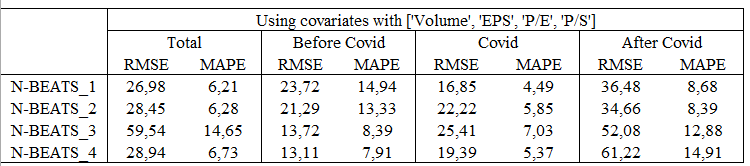

In [17]:
# model_par1 define 
model_par_1 = NBEATSModel(
    input_chunk_length=20,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=1, num_blocks=2, num_layers=1,
    n_epochs=10,
    activation='LeakyReLU',
    dropout=0.001,
    random_state = 42
)
# total 
model_par_1.fit(train['Close'], past_covariates=past_cov_train_vf)
pred_series = model_par_1.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_test_vf,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test['Close'])

# Model Evaluation
print("NBEATS_total_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_total_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_total_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# Before Covid
model_par_1.fit(train_before_covid['Close'], past_covariates=pc_train_before_vf)
pred_series = model_par_1.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_before_vf,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_before_covid['Close'])

# Model Evaluation
print("NBEATS_Covid_Before_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_Covid_Before_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_Covid_Before_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# Covid
model_par_1.fit(train_covid['Close'], past_covariates=pc_train_covid_vf)
pred_series = model_par_1.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_covid_vf,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_covid['Close'])

# Model Evaluation
print("NBEATS_Covid_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_Covid_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_Covid_M1 MAPE = %.2f" % mape(actual_price, pred_price))

# After Covid
model_par_1.fit(train_after_covid['Close'], past_covariates=pc_train_after_covid_vf)
pred_series = model_par_1.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_after_covid_vf,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_after_covid['Close'])

# Model Evaluation
print("NBEATS_After_Covid_M1 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_After_Covid_M1 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_After_Covid_M1 MAPE = %.2f" % mape(actual_price, pred_price))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 58.7 K
---------------------------------------------------
56.8 K    Trainable params
1.9 K     Non-trainable params
58.7 K    Total params
0.235     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_total_M1 RMSE = 26.98
NBEATS_total_M1 R2 = 0.37
NBEATS_total_M1 MAPE = 6.21


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_Covid_Before_M1 RMSE = 23.72
NBEATS_Covid_Before_M1 R2 = -14.95
NBEATS_Covid_Before_M1 MAPE = 14.94


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_Covid_M1 RMSE = 16.85
NBEATS_Covid_M1 R2 = -0.53
NBEATS_Covid_M1 MAPE = 4.49


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_After_Covid_M1 RMSE = 36.48
NBEATS_After_Covid_M1 R2 = -2.68
NBEATS_After_Covid_M1 MAPE = 8.68


In [18]:
model_par_2 = NBEATSModel(
    input_chunk_length=20,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=1, num_blocks=4, num_layers=2,
    n_epochs=20,
    activation='LeakyReLU',
    dropout=0.001,
    random_state = 42
)
# total 
model_par_2.fit(train['Close'], past_covariates=past_cov_train_vf)
pred_series = model_par_2.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_test_vf,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test['Close'])

# Model Evaluation
print("NBEATS_total_M2 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_total_M2 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_total_M2 MAPE = %.2f" % mape(actual_price, pred_price))

# Before Covid
model_par_2.fit(train_before_covid['Close'], past_covariates=pc_train_before_vf)
pred_series = model_par_2.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_before_vf,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_before_covid['Close'])

# Model Evaluation
print("NBEATS_Covid_Before_M2 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_Covid_Before_M2 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_Covid_Before_M2 MAPE = %.2f" % mape(actual_price, pred_price))

# Covid
model_par_2.fit(train_covid['Close'], past_covariates=pc_train_covid_vf)
pred_series = model_par_2.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_covid_vf,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_covid['Close'])

# Model Evaluation
print("NBEATS_Covid_M2 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_Covid_M2 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_Covid_M2 MAPE = %.2f" % mape(actual_price, pred_price))

# After Covid
model_par_2.fit(train_after_covid['Close'], past_covariates=pc_train_after_covid_vf)
pred_series = model_par_2.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_after_covid_vf,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_after_covid['Close'])

# Model Evaluation
print("NBEATS_After_Covid_M2 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_After_Covid_M2 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_After_Covid_M2 MAPE = %.2f" % mape(actual_price, pred_price))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 380 K 
---------------------------------------------------
378 K     Trainable params
1.9 K     Non-trainable params
380 K     Total params
1.522     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_total_M2 RMSE = 28.45
NBEATS_total_M2 R2 = 0.30
NBEATS_total_M2 MAPE = 6.28


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_Covid_Before_M2 RMSE = 21.29
NBEATS_Covid_Before_M2 R2 = -11.85
NBEATS_Covid_Before_M2 MAPE = 13.33


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_Covid_M2 RMSE = 22.22
NBEATS_Covid_M2 R2 = -1.66
NBEATS_Covid_M2 MAPE = 5.85


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_After_Covid_M2 RMSE = 34.66
NBEATS_After_Covid_M2 R2 = -2.32
NBEATS_After_Covid_M2 MAPE = 8.39


In [24]:
model_par_3 = NBEATSModel(
    input_chunk_length=20,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=2, num_blocks=4, num_layers=2,
    n_epochs=30,
    activation='LeakyReLU',
    dropout=0.001,
    random_state = 42
)
# total 
model_par_3.fit(train['Close'], past_covariates=past_cov_train_vf)
pred_series = model_par_3.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_test_vf,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test['Close'])

# Model Evaluation
print("NBEATS_total_M3 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_total_M3 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_total_M3 MAPE = %.2f" % mape(actual_price, pred_price))

# Before Covid
model_par_3.fit(train_before_covid['Close'], past_covariates=pc_train_before_vf)
pred_series = model_par_3.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_before_vf,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_before_covid['Close'])

# Model Evaluation
print("NBEATS_Covid_Before_M3 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_Covid_Before_M3 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_Covid_Before_M3 MAPE = %.2f" % mape(actual_price, pred_price))

# Covid
model_par_3.fit(train_covid['Close'], past_covariates=pc_train_covid_vf)
pred_series = model_par_3.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_covid_vf,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_covid['Close'])

# Model Evaluation
print("NBEATS_Covid_M3 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_Covid_M3 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_Covid_M3 MAPE = %.2f" % mape(actual_price, pred_price))

# After Covid
model_par_3.fit(train_after_covid['Close'], past_covariates=pc_train_after_covid_vf)
pred_series = model_par_3.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_after_covid_vf,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_after_covid['Close'])

# Model Evaluation
print("NBEATS_After_Covid_M3 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_After_Covid_M3 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_After_Covid_M3 MAPE = %.2f" % mape(actual_price, pred_price))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 760 K 
---------------------------------------------------
759 K     Trainable params
1.9 K     Non-trainable params
760 K     Total params
3.044     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_total_M3 RMSE = 59.54
NBEATS_total_M3 R2 = -2.06
NBEATS_total_M3 MAPE = 14.65


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_Covid_Before_M3 RMSE = 13.72
NBEATS_Covid_Before_M3 R2 = -4.34
NBEATS_Covid_Before_M3 MAPE = 8.39


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_Covid_M3 RMSE = 25.41
NBEATS_Covid_M3 R2 = -2.48
NBEATS_Covid_M3 MAPE = 7.03


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_After_Covid_M3 RMSE = 52.08
NBEATS_After_Covid_M3 R2 = -6.49
NBEATS_After_Covid_M3 MAPE = 12.88


In [20]:
model_par_4 = NBEATSModel(
    input_chunk_length=20,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=2, num_blocks=6, num_layers=2,
    n_epochs=50,
    activation='LeakyReLU',
    dropout=0.001,
    random_state = 42
)
# total 
model_par_4.fit(train['Close'], past_covariates=past_cov_train_vf)
pred_series = model_par_4.historical_forecasts(
    series=test['Close'],
    forecast_horizon=10,
    past_covariates=past_cov_test_vf,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test['Close'])

# Model Evaluation
print("NBEATS_total_M4 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_total_M4 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_total_M4 MAPE = %.2f" % mape(actual_price, pred_price))

# Before Covid
model_par_4.fit(train_before_covid['Close'], past_covariates=pc_train_before_vf)
pred_series = model_par_4.historical_forecasts(
    series=test_before_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_before_vf,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_before_covid['Close'])

# Model Evaluation
print("NBEATS_Covid_Before_M4 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_Covid_Before_M4 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_Covid_Before_M4 MAPE = %.2f" % mape(actual_price, pred_price))

# Covid
model_par_4.fit(train_covid['Close'], past_covariates=pc_train_covid_vf)
pred_series = model_par_4.historical_forecasts(
    series=test_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_covid_vf,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_covid['Close'])

# Model Evaluation
print("NBEATS_Covid_M4 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_Covid_M4 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_Covid_M4 MAPE = %.2f" % mape(actual_price, pred_price))

# After Covid
model_par_4.fit(train_after_covid['Close'], past_covariates=pc_train_after_covid_vf)
pred_series = model_par_4.historical_forecasts(
    series=test_after_covid['Close'],
    forecast_horizon=10,
    past_covariates=pc_test_after_covid_vf,
    retrain=False,
    verbose=False)

# scaler inverse
pred_price = scaler.inverse_transform(pred_series)
actual_price = scaler.inverse_transform(test_after_covid['Close'])

# Model Evaluation
print("NBEATS_After_Covid_M4 RMSE = %.2f" % rmse(actual_price, pred_price))
print("NBEATS_After_Covid_M4 R2 = %.2f" % r2_score(actual_price, pred_price))
print("NBEATS_After_Covid_M4 MAPE = %.2f" % mape(actual_price, pred_price))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 1.1 M 
---------------------------------------------------
1.1 M     Trainable params
1.9 K     Non-trainable params
1.1 M     Total params
4.566     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_total_M4 RMSE = 28.94
NBEATS_total_M4 R2 = 0.28
NBEATS_total_M4 MAPE = 6.73


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_Covid_Before_M4 RMSE = 13.11
NBEATS_Covid_Before_M4 R2 = -3.87
NBEATS_Covid_Before_M4 MAPE = 7.91


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_Covid_M4 RMSE = 19.39
NBEATS_Covid_M4 R2 = -1.02
NBEATS_Covid_M4 MAPE = 5.37


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS_After_Covid_M4 RMSE = 61.22
NBEATS_After_Covid_M4 R2 = -9.36
NBEATS_After_Covid_M4 MAPE = 14.91
